In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [ ]:
# Image size and batch size
image_size = (224, 224)
batch_size = 32
train_dir = 'data/train'
test_dir = 'data/test'

# Generate data by modifiying oringal dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    'data/train',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = False,
    subset='training'
)

val_data = train_datagen.flow_from_directory(
    'data/train',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = False,
    subset='validation'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = False,
)

Found 570 images belonging to 3 classes.
Found 141 images belonging to 3 classes.
Found 114 images belonging to 3 classes.


In [19]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False 

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(train_data.num_classes, activation='softmax')
])


# Compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [20]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=40,
    callbacks=[early_stop, reduce_lr]
)

# Evaluation
y_true = test_data.classes
y_pred_probs = model.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1)

c:\Users\wongb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 740ms/step - accuracy: 0.3143 - loss: 1.5124 - val_accuracy: 0.4326 - val_loss: 1.1228 - learning_rate: 1.0000e-04
Epoch 2/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 621ms/step - accuracy: 0.3587 - loss: 1.3009 - val_accuracy: 0.4397 - val_loss: 1.0915 - learning_rate: 1.0000e-04
Epoch 3/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 630ms/step - accuracy: 0.3955 - loss: 1.2591 - val_accuracy: 0.4752 - val_loss: 1.0135 - learning_rate: 1.0000e-04
Epoch 4/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 658ms/step - accuracy: 0.5026 - loss: 1.0259 - val_accuracy: 0.5532 - val_loss: 0.9827 - learning_rate: 1.0000e-04
Epoch 5/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 648ms/step - accuracy: 0.5236 - loss: 0.9865 - val_accuracy: 0.5532 - val_loss: 0.9473 - learning_rate: 1.0000e-04
Epoch 6/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 622ms/step - accuracy: 0.5117 - loss: 1.0352 - val_accuracy: 0.5674 - val_loss: 0.9065 - learning_rate: 1.0000e-04
Epoch 7/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 604ms/step - acc

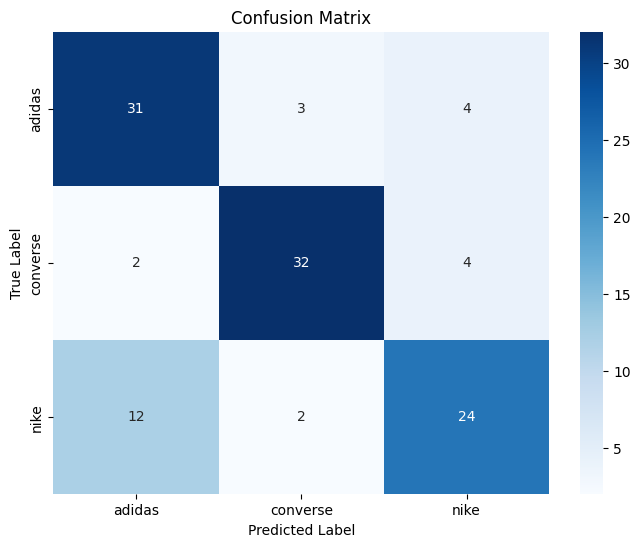

In [21]:
# Confusion Matrix and Classification Report
cm = confusion_matrix(y_true, y_pred)
class_names = list(test_data.class_indices.keys())

# Plot Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [22]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      adidas       0.69      0.82      0.75        38
    converse       0.86      0.84      0.85        38
        nike       0.75      0.63      0.69        38

    accuracy                           0.76       114
   macro avg       0.77      0.76      0.76       114
weighted avg       0.77      0.76      0.76       114

